### Imports

In [ ]:
%%capture
import pymongo
import os
import time
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
from pandas.plotting import register_matplotlib_converters
import datetime as dt
import numpy as np
import dask.bag as daskdb
import random
import glob
import pandas as pd
import json
import math
import locale

### Functions

In [ ]:
class Timer():
    def start(self):
        self.start_time = time.time()
    
    def end(self):
        self.end_time = time.time()
        diff = self.end_time - self.start_time
        if diff > 60:
            minutes = math.floor(diff / 60)
            print(f"Time elapsed: {minutes:,} mins {diff - minutes*60:.2f} seconds.")
        else:
            print(f"Time elapsed: {diff:.2f} seconds.")
timer = Timer()

# Add Citations to appeals metadata
def add_citations_to_metadata(appeals_metadata, list_citations, single_issue_ids):
    for citation in list_citations:
        df = pd.DataFrame(list(db.citations.find(
            {
                "bva_id": {"$in": single_issue_ids},
                'citations': {'$elemMatch': {'case': citation[1]}}
             }, 
            {'_id' : 0, 'bva_id': 1}
        )))
        cases = list(df.bva_id)
        appeals_metadata[citation[0]] = appeals_metadata["tiread2"].isin(cases)
    return appeals_metadata

# Read full appeals metadata from GCP if available, otherwise read from
# mongodb and write to GCP
def read_single_issue_metadata(gcp_folder, mongodb_cursor):
    filename = "appeals_meta_single_issue.csv"
    timer.start()
    if filename in os.listdir(gcp_folder):
        print("Reading a stored copy from GCP...")
        single_issue = pd.read_csv(f"{gcp_folder}/{filename}",
                              dtype={"tiread2": object},
                              parse_dates=["timestamp"])
    else:
        print("Reading from Mongodb...")
        # Filter for single_issue
        df_meta = pd.DataFrame(list(mongodb_cursor.appeals_meta_wscraped.find({}, {"_id": 0})))
        df_meta["issue_count"] = df_meta["issue_count"].astype(int)
        single_issue_ids = df_meta[df_meta["issue_count"] == 1].tiread2.tolist()
        single_issue = df_meta.query("issue_count == 1")
        del df_meta
        print("Loaded Single Issue data.")

        # Format
        single_issue["timestamp"] = pd.to_datetime(single_issue['imgadtm'], utc=True)
        single_issue["appealed_CAVC"] = single_issue["appealed_CAVC"].astype(int)
        single_issue["appealed_cavc_appeal_level"] = single_issue["appealed_cavc_appeal_level"].astype(int)
        single_issue["cvjoint"] = single_issue["cvjoint"].astype(int)
        single_issue["jmr_appeal_level"] = single_issue["jmr_appeal_level"].astype(int)       

        # Add citations
        list_citations = [['thun_peake', '22 Vet. App. 111'],
                          ['scott_mcd', '789 F.3d 1375'],
                          ['johnson_mcd', '762 F.3d 1362']]
        single_issue = add_citations_to_metadata(single_issue, list_citations, single_issue_ids)
        print("Added citations.")
        single_issue.to_csv(f"{gcp_folder}/{filename}", index=False)
    timer.end()
    return single_issue

### Config

In [ ]:
%%capture
# Settings
register_matplotlib_converters()
plt.rcParams['figure.figsize'] = [12, 6]
plt.rc('font', size=12)
pd.options.mode.chained_assignment = None   # To prevent stupid warnings
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# connect to mongo database
os.chdir('/bva-data/')
from db_config import *
db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
db.authenticate(DB_USER, DB_PASSWORD)

In [5]:
# List collections in DB
for name in db.list_collection_names():
    print(f"{name}: {db[name].estimated_document_count():,}")

appeals_meta_old: 1,907,349
citations: 1,024,074
appeals_meta: 2,261,400
answer-feedback: 1
annotations: 330
answer.feedback: 25,367
users: 117
code_dictionary: 3
documents: 1,024,074
appeals_meta_wscraped: 2,261,400


### Match VLJ Extraction

In [6]:
# Get metadata for single issue cases
single_issue = read_single_issue_metadata(".", db)

Reading a stored copy from GCP...
Time elapsed: 4.53 seconds.


In [7]:
# Quick check of 10 documents to see if extracted vljs match metadata
list_ids = single_issue.head(10)["tiread2"].tolist()
extracted_vljs = pd.DataFrame(list(db.documents.find(
        {"bva_id": {"$in": list_ids}},
        {"_id": 0, "bva_id": 1, "vlj_names": 1}
)))
for found_id in list_ids:
    extracted = extracted_vljs.query(f"bva_id == '{found_id}'")["vlj_names"].values[0]
    from_metadata = single_issue.query(f"tiread2 == '{found_id}'")["vlj_name"].values[0]
    print(f"Extracted: {','.join(extracted)} Metadata: {from_metadata}")

Extracted: S.  Bush Metadata: BUSH,SONNET B
Extracted:  Metadata: DAY,JONATHAN E
Extracted:  Metadata: DAY,JONATHAN E
Extracted:  Metadata: BRUCE,CYNTHIA M
Extracted: W. M. Braeuer Metadata: BRAEUER,WAYNE M
Extracted:  Metadata: PRICHARD,JOHN L
Extracted:  Metadata: PRICHARD,JOHN L
Extracted:  Metadata: PELLETIER,RENEE M
Extracted: R. C. Scharnberger Metadata: SCHARNBERGER,ROBERT C
Extracted: R. C. Scharnberger Metadata: SCHARNBERGER,ROBERT C


### VLJ Summary Stats

In [8]:
single_issue.vlj_name.value_counts()

SENYK,GEORGE R            6989
KENNEDY,SUSAN L           6735
LYON,MICHAEL D            6487
POWELL,URSULA R           6467
SCHWARTZ,HOWARD N         6049
                          ... 
MORAN,CHRISTOPHER B          1
CHRISTIAN,FRANK L  III       1
SHOREMAN,SCOTT J             1
TAYLOR,MELANIE B             1
YEAGER,THOMAS A              1
Name: vlj_name, Length: 355, dtype: int64

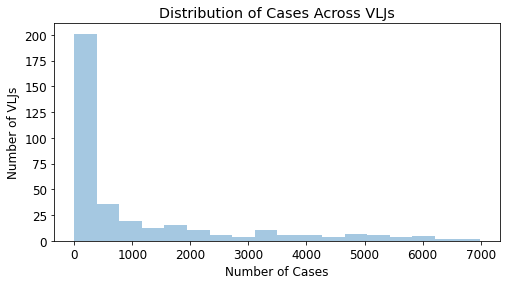

In [9]:
plt.rcParams["figure.figsize"] = [8,4]
_ = sns.distplot(single_issue.vlj_name.value_counts(), kde=False)
_ = plt.xlabel("Number of Cases")
_ = plt.ylabel("Number of VLJs")
_ = plt.title("Distribution of Cases Across VLJs")

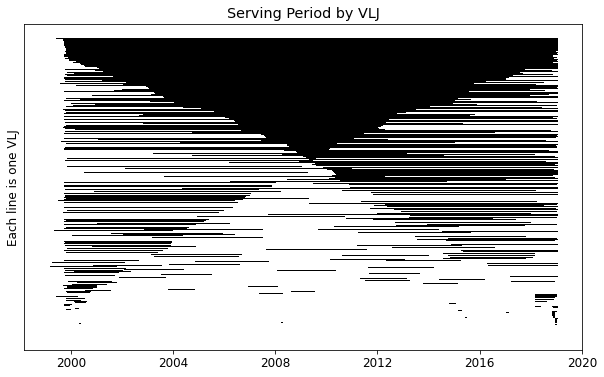

In [10]:
def plot_serving_duration_per_vlj(df):
    plt.rcParams["figure.figsize"] = [10,6]
    min_df = df.groupby("vlj_name").timestamp.min().rename("min_date")
    max_df = df.groupby("vlj_name").timestamp.max().rename("max_date")
    temp = min_df.to_frame().join(max_df, on="vlj_name").reset_index()
    temp["duration"] = temp["max_date"] - temp["min_date"]
    temp.sort_values("duration", inplace=True)
    temp.reset_index(inplace=True)

    for i in range(temp.shape[0]):
        x = [temp["min_date"][i], temp["max_date"][i]]
        y = [i, i]
        plt.plot(x, y, color="black", lw=1)
    _ = plt.title("Serving Period by VLJ")
    _ = plt.gca().get_yaxis().set_ticks([])
    _ = plt.ylabel("Each line is one VLJ")
plot_serving_duration_per_vlj(single_issue)

### Data Processing Functions

In [ ]:
# Function to plot before/after comparison of citation by VLJ,
# given a case name. Size encodes number of cases.
def plot_citation_across_vljs(df, subset_condition, case_name, intervention_date,
                              min_count=5, month_span=4, after_threshold=100):
    plt.rcParams["figure.figsize"] = [8,7]
    date = f"{intervention_date.year}-{intervention_date.month}-{intervention_date.day}"
    intervention_date = pd.Timestamp(intervention_date, tz='UTC')

    # Subset for condition and intervention_date +- 4 months
    df_subset = single_issue.query(subset_condition)
    min_date = intervention_date - pd.DateOffset(months=month_span)
    max_date = intervention_date + pd.DateOffset(months=month_span)
    df_subset = df_subset.query("timestamp > @min_date & timestamp < @max_date")
    df_subset["period"] = np.where(df_subset["timestamp"] > intervention_date, "After", "Before")

    # Calculate counts Before/After
    temp = df_subset.groupby(["period", "vlj_name"])\
        .agg(count = (case_name, "count"),
            cited = (case_name, "sum"))\
        .reset_index()\
        .fillna(0)
    temp["citation_rate"] = temp["cited"] / temp["count"] * 100
    temp = temp.pivot(index="vlj_name", columns="period").fillna(0)
    temp.columns = [f"{t[0]}_{t[1]}" for t in temp.columns.to_flat_index()]
    temp = temp.query("count_After > @min_count & count_Before > @min_count")
    temp["diff_citation_rate"] = temp["citation_rate_After"] - temp["citation_rate_Before"]
    temp.sort_values("diff_citation_rate", inplace=True)

    # List of outlier judges
    def cast_str(series_obj):
        return series_obj.astype(int).astype(str)
    criteria_outlier = f"(diff_citation_rate >= 0 or citation_rate_After > {after_threshold})"
    criteria_outlier += " & ~(cited_Before==0 & cited_After==0)"
    vlj_list = temp.query(criteria_outlier)
    vlj_list.sort_values("diff_citation_rate", ascending=False, inplace=True)
    vlj_list["Before"] = cast_str(vlj_list["cited_Before"]) + "/" + cast_str(vlj_list["count_Before"])
    vlj_list["Before %"] = cast_str(vlj_list["citation_rate_Before"]) + "%"
    vlj_list["After"] = cast_str(vlj_list["cited_After"]) + "/" + cast_str(vlj_list["count_After"])
    vlj_list["After %"] = cast_str(vlj_list["citation_rate_After"]) + "%"
    vlj_list["Diff %"] = cast_str(vlj_list["diff_citation_rate"]) + "%"
    vlj_list = vlj_list.loc[:, ["Before", "Before %", "After", "After %", "Diff %"]].reset_index()

    # Plot
    colors = ["crimson", "mediumblue", "black"]
    avg_size = temp["count_After"].mean()
    for vlj in list(temp.index):
        temp_data = temp.loc[vlj]
        x = ["Before", "After"]
        y = [temp_data["citation_rate_Before"], temp_data["citation_rate_After"]]
        change = temp_data["diff_citation_rate"]
        size = temp_data["count_After"]
        if change > 0:
            color = colors[1]
        elif change < 0:
            color = colors[0]
        else:
            color = colors[2]
        plt.plot(x, y, color=color, lw=size/avg_size*3, alpha=0.8)

        if vlj in list(vlj_list["vlj_name"]):
            plt.text(x[1], y[1], vlj, c=color, fontsize=9, verticalalignment='center')
    title = f"Change in Citation Rate after Intervention on {date}"
    title += f"\n{month_span} months Before/After"
    _ = plt.title(title)
    _ = plt.ylabel("Citation Rate (%)")
    _ = plt.xlim(-0.1, 1.5)

    # Add legend
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = ['Decrease', 'Increase', 'No Change']
    plt.legend(lines, labels, loc=(1.05, 0.5))
    return temp, vlj_list

def print_df(df):
    text = ""
    text += ",".join(vlj_list.columns) + "\n"
    for record in vlj_list.to_records(index=False):
        record = [str(item).replace(",", " ") for item in record]
        line = ",".join(record)
        line += "\n"
        text += line
    print(text)

### Thun V. Peake

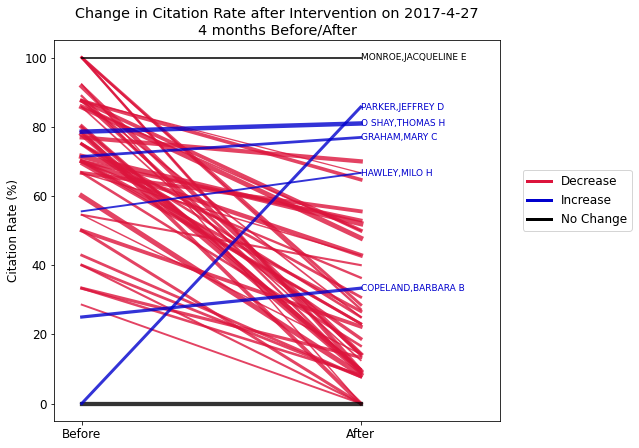

In [40]:
cond = "issprog == '2' & isscode == '12' & (issdc in ['1','4'])" 
plot_data, vlj_list = plot_citation_across_vljs(single_issue, 
                          subset_condition=cond,
                          case_name="thun_peake",
                          intervention_date=dt.datetime(2017, 4, 27), 
                          min_count=5,
                          month_span=4)

In [41]:
print_df(vlj_list)

vlj_name,Before,Before %,After,After %,Diff %
PARKER JEFFREY D,0/13,0%,12/14,85%,85%
HAWLEY MILO H,5/9,55%,6/9,66%,11%
COPELAND BARBARA B,2/8,25%,5/15,33%,8%
GRAHAM MARY C,10/14,71%,10/13,76%,5%
O SHAY THOMAS H,11/14,78%,17/21,80%,2%
MONROE JACQUELINE E,6/6,100%,9/9,100%,0%



### Scott v. McDonald

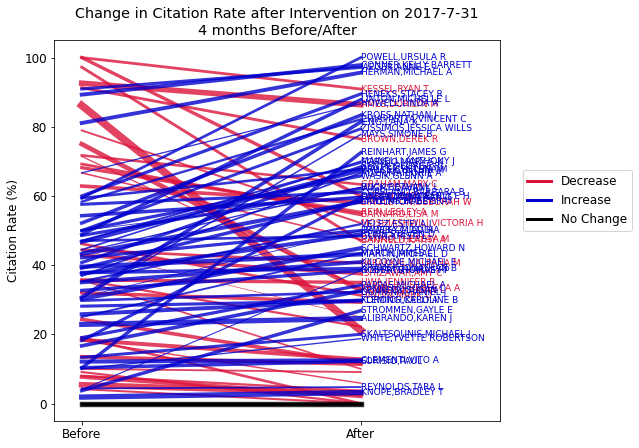

In [46]:
cond = "issprog == '2' & issdc == '4'" 
plot_data, vlj_list = plot_citation_across_vljs(single_issue, 
                          subset_condition=cond,
                          case_name="scott_mcd",
                          intervention_date=dt.datetime(2017, 7, 31), 
                          min_count=5,
                          month_span=4,
                          after_threshold=30)

In [43]:
print_df(vlj_list)

vlj_name,Before,Before %,After,After %,Diff %
GUNN KRISTI L,16/31,51%,5/15,33%,-18%



### Johnson V. McDonald

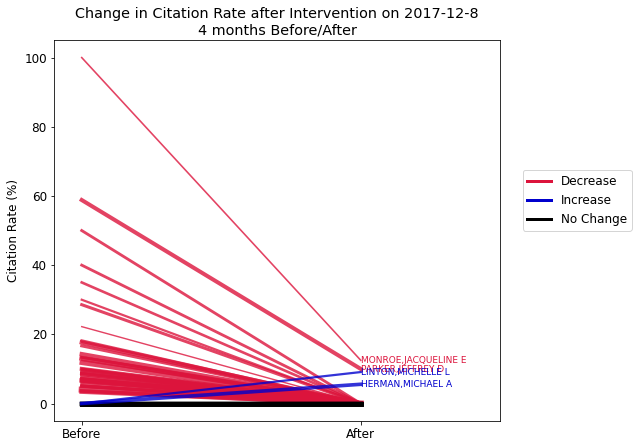

In [44]:
cond = "issprog == '2' & isscode == '12' & (issdc in ['1','4'])" 
plot_data, vlj_list = plot_citation_across_vljs(single_issue, 
                          subset_condition=cond,
                          case_name="johnson_mcd",
                          intervention_date=dt.datetime(2017, 12, 8), 
                          min_count=5,
                          month_span=4,
                          after_threshold=0)

In [45]:
print_df(vlj_list)

vlj_name,Before,Before %,After,After %,Diff %
LINTON MICHELLE L,0/8,0%,1/11,9%,9%
HERMAN MICHAEL A,0/19,0%,1/18,5%,5%
PARKER JEFFREY D,10/17,58%,2/20,10%,-48%
MONROE JACQUELINE E,6/6,100%,1/8,12%,-87%

